## Assignment 2 - Image Classification

Vijay Iyer s3797863

## Importing the libraries

In [26]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Importing Data and Exploration

In [2]:
main_df = pd.read_csv("data_labels_mainData.csv")

In [3]:
main_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


## Showing image of each cell type

In [4]:
def show_images(df):
    explore_df = df.groupby("cellTypeName").first()
    
    image_list = []
    image_names = []
    for ind, row in explore_df.iterrows():
        img = cv2.imread("patch_images/"+row["ImageName"])
        image_list.append(img)
        image_names.append(ind)
    
    fig = plt.figure(figsize=(10, 10))
    rows = 2
    columns = 2
    axis_list = []
    for i in range(explore_df.shape[0]):
        axis_list.append(plt.subplot(1,explore_df.shape[0],i+1))
                     
    for i,ax in enumerate(axis_list):
        ax.imshow(image_list[i])
        ax.set_title(image_names[i])

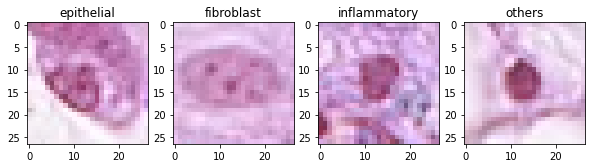

In [5]:
show_images(main_df)

## Showing Images of each cell type (multiple)

In [6]:
def show_multiple_images(df, cellType):
    df = df[df["cellTypeName"] == cellType]
    explore_df = df.sample(5)
    
    image_list = []
    for ind, row in explore_df.iterrows():
        img = cv2.imread("patch_images/"+row["ImageName"])
        image_list.append(img)
    
    fig = plt.figure(figsize=(10, 10))
    axis_list = []
    for i in range(explore_df.shape[0]):
        axis_list.append(plt.subplot(1,explore_df.shape[0],i+1))
                     
    for i,ax in enumerate(axis_list):
        ax.imshow(image_list[i])
        ax.set_title(val)

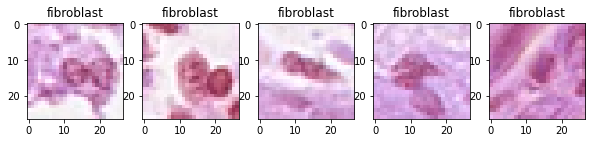

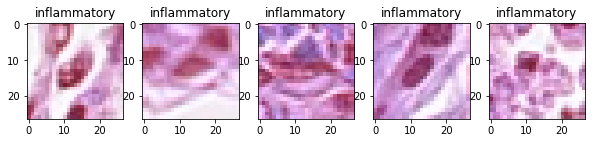

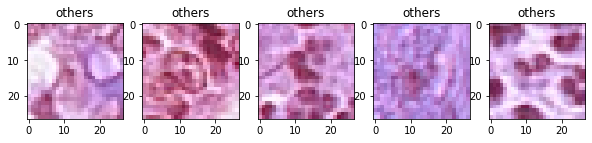

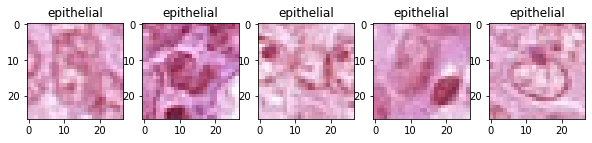

In [7]:
for val in main_df["cellTypeName"].unique():
    show_multiple_images(main_df, val)

Above image plot shows that - 
* For each cell type, there are representations of image. This would prove a crucial factor when developing the deep learning model, as the model has to learn from each representations of cell type.

## More Data Exploration

Number of images for each cell type:


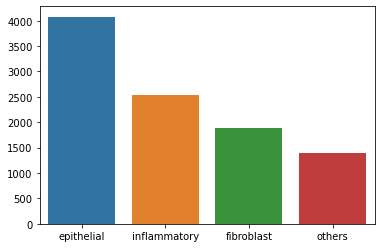

In [8]:
print("Number of images for each cell type:")

ax = sns.barplot(x=main_df["cellTypeName"].value_counts().index, y=main_df["cellTypeName"].value_counts().values, data=main_df)

The above bar plot, shows that the image classification model might do well for the epithelial cell type, as it contains close to 4000 images, double of fibroblast and others cell type.

Since this task, is to identify the images as cell type, we can remove the column IsCancerous, InstanceID and the patientID. But we can keep the patientid , because there are multiple records for one single patient Id. We can use this to stratify the train test split, making the split evenly distributed.

In [9]:
main_df.drop(columns = ["isCancerous", "InstanceID"], inplace=True)

In [10]:
main_df.head()

,patientID,ImageName,cellTypeName,cellType
0,1,22405.png,fibroblast,0
1,1,22406.png,fibroblast,0
2,1,22407.png,fibroblast,0
3,1,22408.png,fibroblast,0
4,1,22409.png,fibroblast,0


In [11]:
main_df.groupby("cellTypeName").first()

,patientID,ImageName,cellType
cellTypeName,,,
epithelial,5,276.png,2
fibroblast,1,22405.png,0
inflammatory,1,22417.png,1
others,1,22423.png,3


As per the above table, "Fibroblast" is represented as 0, "Inflammatory" as 1, "Epithelial" as 2 and "others" as 3. Since we have cellType, there is no need for cellTypeName

In [12]:
main_df.drop(columns = ["cellTypeName"], inplace = True)

In [13]:
main_df.head()

,patientID,ImageName,cellType
0,1,22405.png,0
1,1,22406.png,0
2,1,22407.png,0
3,1,22408.png,0
4,1,22409.png,0


In [14]:
def add_path(image):
    return "./patch_images/"+image

main_df["ImageName"] = main_df["ImageName"].apply(add_path)

In [15]:
main_df.head()

,patientID,ImageName,cellType
0,1,./patch_images/22405.png,0
1,1,./patch_images/22406.png,0
2,1,./patch_images/22407.png,0
3,1,./patch_images/22408.png,0
4,1,./patch_images/22409.png,0


In [16]:
main_df.shape

(9896, 3)

## Splitting the dataset

Let's split the dataset into train, valid and test. For the training purpose, we will divide the data into 20% for test and 20% validation data out of total.

In [17]:
train_data, test_data = train_test_split(main_df, test_size=0.20, random_state=9, stratify = main_df.patientID)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=9, stratify = train_data.patientID)

train_data.drop(columns = ["patientID"], inplace=True)
test_data.drop(columns = ["patientID"], inplace=True)
val_data.drop(columns = ["patientID"], inplace=True)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 6332, Val Data: 1584, Test Data: 1980


In [18]:
train_data.cellType.value_counts()

2    2629
1    1588
0    1230
3     885
Name: cellType, dtype: int64

The above value count table shows kind of imbalance for the cell type "3" - others. This might affect the performance of the model.

#### Exploring the distribution of target feature in train, test, valid

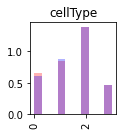

In [19]:
plt.figure(figsize=(20,20))

for i, col in enumerate(train_data.columns):

    if col != 'ImageName':
        plt.subplot(10,11,i+1)
        if train_data[col].dtypes != np.int64:
            plt.bar(train_data[col].value_counts().index.astype(str), 
                    train_data[col].value_counts().values/np.sum(train_data[col].value_counts().values), 
                    alpha=0.3, color='r')
            plt.bar(test_data[col].value_counts().index.astype(str), 
                    test_data[col].value_counts().values/np.sum(test_data[col].value_counts().values), 
                    alpha=0.3, color='b')
        else:
            plt.hist(train_data[col], alpha=0.3, color='r', density=True)
            plt.hist(test_data[col], alpha=0.3, color='b', density=True)

        plt.title(col)
        plt.xticks(rotation='vertical')

The above distribution of cell Type in each train, test and validatio data proves to be pretty much the same, indicating the right split ratio.

## Plot for showing the distribution of Accuracy and Loss on the train and validation data over number of epochs

This method will be used to plot the accuracy and loss graph for the train and validation dataset.

In [20]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Generating Confusion Matrix, F1_score, Precision and Recall

This method will be used to produce statistics like the f1 score, precision and recall

In [21]:
def generate_stats_cellType(generator,model_VGG_1):
    y_hat_all = list()
    y_all = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0
    batch_size = 1

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            y_hat = model_VGG_1.predict(x, verbose=0)
            y_hat = np.argmax(y_hat, axis = 1)
            y = np.argmax(y, axis = 1)
            y_hat_all = y_hat_all + y_hat.tolist()
            y_all = y_all + y.tolist()

            batches += 1
            if batches >= N_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break

    # now you have made the predictions you can use any performance metric
    # you wish: either in sklearn or some function you have written

    print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
    print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
    print("Precision Score: ", precision_score(y_all, y_hat_all, average="macro"))
    print("Recall Score: ", recall_score(y_all,y_hat_all, average="macro"))
    print(confusion_matrix(y_all, y_hat_all))

## Image Generator for CellType

The below block is used to generator data generators for the train, test and validation. For the train and validation, we will use batch size of 128 and for test, we will use batch size of 1. This batch size decides how much images the training set receives in each iteration. This is crucial, as our train dataset containes less images for cell type 3 and more batch size means it will receive few images of cell type 3 for training in each iteration.

In [22]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
test_data['cellType'] = test_data['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=128,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=128,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=1,
        class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


## MLP model 

This function is used to build MLP with a specific number of hidden layer

In [23]:
def set_NN_model(INPUT_DIM, HIDDEN_LAYER_DIM, OUTPUT_CLASSES, Activation = "sigmoid"):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation=Activation),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])
    
    return model

This function is used to compile the model built above. For MLP, we will use SGD optimizer with loss as CategoricalCrossEntropy and metric as categorical accuracy, which is required for multiclass classification

In [24]:
def compile_model(model, Optimizer = "SGD", Metric = 'categorical_accuracy'):
    model.compile(optimizer=Optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[Metric])
    return model

MLP model is developed below with neurons in the hidden layer and statistics for each model is also produced below.

Building MLP for  256  neurons in hidden layer
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________
None
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
None


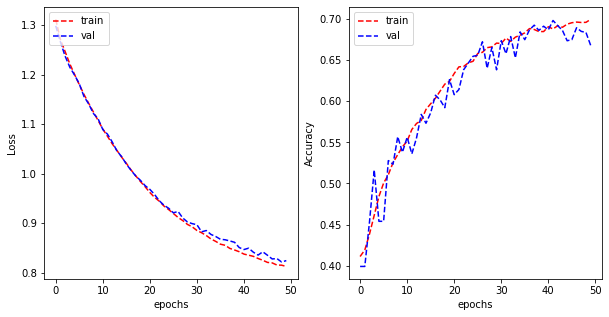

1980/1980 [==============================] - 1s 666us/step - loss: 0.8295 - categorical_accuracy: 0.6732
Model Evaluation:  [0.8295050263404846, 0.6732323169708252]
Accuracy score:  0.6732323232323232
F1 score:  0.512296015870202
Precision Score:  0.601531266558656
Recall Score:  0.5423280751841761
[[162 106  92   4]
 [ 19 407  95   2]
 [  4  55 759   0]
 [ 78 136  56   5]]
*** End of training ***
Building MLP for  512  neurons in hidden layer
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1120256   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 1,122,308
Trainable params: 1,122,308
Non-trainable pa

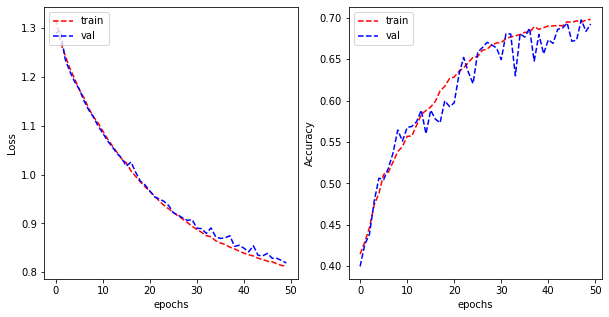

1980/1980 [==============================] - 2s 769us/step - loss: 0.8291 - categorical_accuracy: 0.6909
Model Evaluation:  [0.8291257619857788, 0.6909090876579285]
Accuracy score:  0.6909090909090909
F1 score:  0.558008013035707
Precision Score:  0.6132678863436061
Recall Score:  0.5748018237074813
[[199  77  70  18]
 [ 22 399  94   8]
 [  8  59 750   1]
 [ 79 128  48  20]]
*** End of training ***
Building MLP for  724  neurons in hidden layer
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 724)               1584112   
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 2900      
Total params: 1,587,012
Trainable params: 1,587,012
Non-trainable p

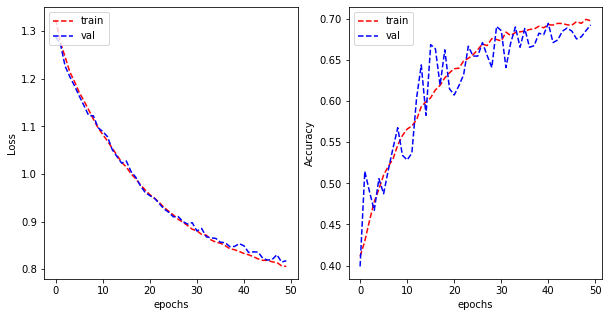

1980/1980 [==============================] - 2s 1ms/step - loss: 0.8294 - categorical_accuracy: 0.6884
Model Evaluation:  [0.829380989074707, 0.6883838176727295]
Accuracy score:  0.6883838383838384
F1 score:  0.5377430377654355
Precision Score:  0.5733792416990187
Recall Score:  0.5751557879399418
[[246  47  68   3]
 [ 52 362 103   6]
 [ 26  41 751   0]
 [118  98  55   4]]
*** End of training ***


In [27]:
hidden_layer = [256,512,724]
input_dimension = (27,27,3)
output_dimension = 4
model_history_list = []

for val in hidden_layer:
    print("Building MLP for ",val," neurons in hidden layer")
    #Building the model
    model = set_NN_model(input_dimension, val, output_dimension)
    #Compiling the model
    model = compile_model(model)
    #Print model stats
    print(model.summary())
    print(tf.keras.utils.plot_model(model, show_shapes=True))
    #Using Early Stopping technique to stop if there is no change in validation loss after 5 epochs
    monitor=EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=5,verbose=1,restore_best_weights=True)
    #Fit the train generator with validation data as validation generator data
    history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0, 
                                  callbacks = [monitor])
    #Plotting the graph for loss for training and validation data for n number of epochs, along with accuracy of the model
    plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Model Evaluation: ", str(model.evaluate(test_generator)))
    generate_stats_cellType(test_generator, model)
    print("*** End of training ***")

Looking at the above results, hidden layer with 512 neurons is out performing the other hyper parameters slightly. So we will go with the second model in the list of model history.

## Deep Learning Model

Since we have created the train, test and validation data generator, we can use the same for the Deep Learning Models as well.

In [28]:
OUTPUT_CLASSES = 4

Initially, we will use the VGG architecture with 3 blocks of convolution-max pooling combination and a fully dense layer with 128 neurons.

In [29]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [30]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [31]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

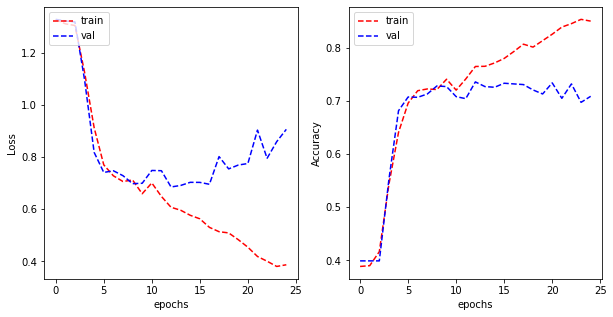

Accuracy score:  0.7419191919191919
F1 score:  0.676316810403355
Precision Score:  0.6778831159433305
Recall Score:  0.6762926031552817
[[254  33  32  45]
 [ 38 379  41  65]
 [ 39  33 728  18]
 [ 54  82  31 108]]


In [32]:
#Calling the plot learning curve function
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#calling the Statistics function
generate_stats_cellType(test_generator, model_VGG_1)

The above model shows good accuracy and f1-score for a deep learning model. However, looking at the accuracy, there is a high overfitting case.

## Tuning Deep Learning Model

To remove this overfitting, we will tune the learning rate and apply l2 regularization on each convolution layer. After seeing the results, if we need to tune more, we will add dropouts. The below function is a tuned VGG architecture. 

In [33]:
def build_model(reg_lambda, learning_rate):
    model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
        #tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
    stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=1e-3, patience=15, verbose=0, mode='auto', restore_best_weights=False)
    
    model_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0, 
                                        callbacks=[stopper])

    plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    print("Performance on test data: ", str(model.evaluate(test_generator)))
    
    generate_stats_cellType(test_generator, model)
    
    print("*** End of training ***")
        
    return model

The following block uses different learning rate and l2 regularization parameter to see on which combination the model is performing better without overfitting.

Training for reg_lamda = 0.001 , learning_rate= 0.001


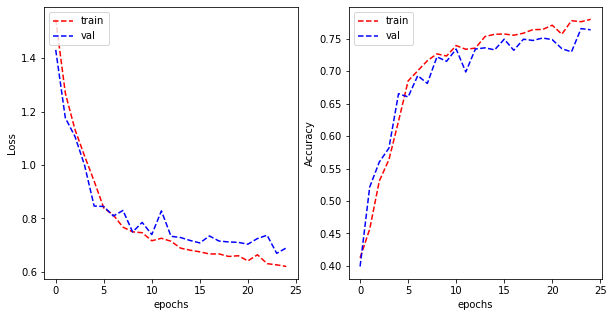

1980/1980 [==============================] - 7s 4ms/step - loss: 0.6646 - categorical_accuracy: 0.7732
Performance on test data:  [0.6646034717559814, 0.7732323408126831]
Accuracy score:  0.7732323232323233
F1 score:  0.6950367966352681
Precision Score:  0.7368774641758169
Recall Score:  0.6913040176525125
[[243  48  38  35]
 [ 14 468  26  15]
 [ 24  56 737   1]
 [ 34 137  21  83]]
*** End of training ***
*** End of iteration ***

Training for reg_lamda = 0.001 , learning_rate= 0.01


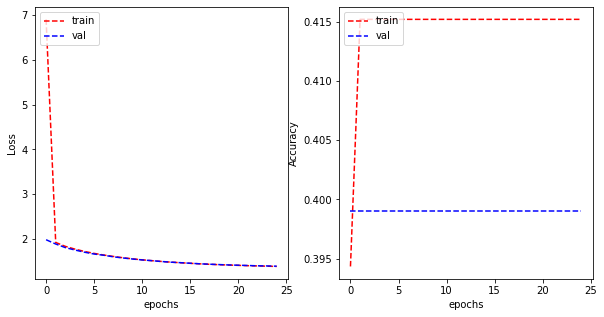

1980/1980 [==============================] - 5s 3ms/step - loss: 1.3766 - categorical_accuracy: 0.4131
Performance on test data:  [1.3766453266143799, 0.41313132643699646]
Accuracy score:  0.4131313131313131
F1 score:  0.14617583988563257
Precision Score:  0.10328282828282828
Recall Score:  0.25
[[  0   0 364   0]
 [  0   0 523   0]
 [  0   0 818   0]
 [  0   0 275   0]]
*** End of training ***
*** End of iteration ***

Training for reg_lamda = 0.01 , learning_rate= 0.001


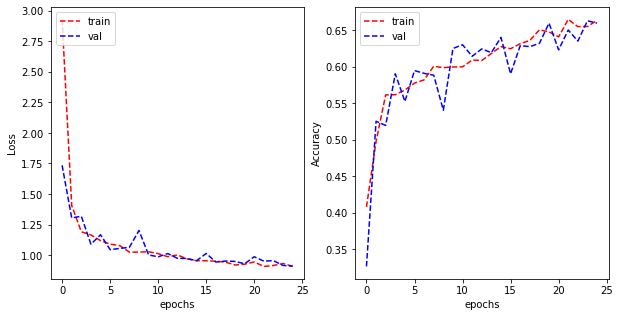

1980/1980 [==============================] - 5s 2ms/step - loss: 0.8924 - categorical_accuracy: 0.6586
Performance on test data:  [0.8923712968826294, 0.6585858464241028]
Accuracy score:  0.6585858585858586
F1 score:  0.4969400349591923
Precision Score:  0.6267166731761147
Recall Score:  0.5315760984984058
[[148 151  63   2]
 [ 43 427  52   1]
 [ 16  78 724   0]
 [ 75 176  19   5]]
*** End of training ***
*** End of iteration ***

Training for reg_lamda = 0.01 , learning_rate= 0.01


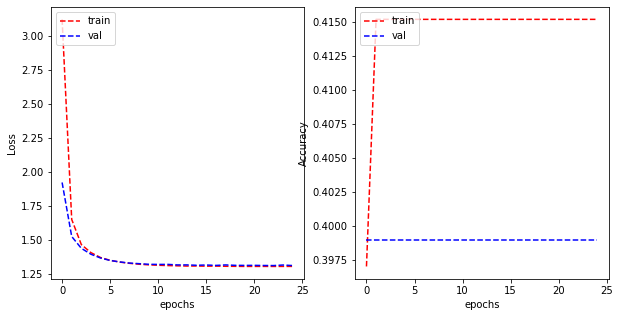

1980/1980 [==============================] - 5s 3ms/step - loss: 1.3039 - categorical_accuracy: 0.4131
Performance on test data:  [1.3038649559020996, 0.41313132643699646]
Accuracy score:  0.4131313131313131
F1 score:  0.14617583988563257
Precision Score:  0.10328282828282828
Recall Score:  0.25
[[  0   0 364   0]
 [  0   0 523   0]
 [  0   0 818   0]
 [  0   0 275   0]]
*** End of training ***
*** End of iteration ***



In [35]:
reg_lambda = [0.001, 0.01]
learning_rate = [0.001, 0.01]

for reg in reg_lambda:
    for lr in learning_rate:
        print("Training for reg_lamda =",reg,", learning_rate=",lr)
                
        build_model(reg, lr)
        
        print("*** End of iteration ***")
            
        print()

Reg = 0.001, learning_rate = 0.001 is doing a great job with very less overfitting. Let's rerun the model and save the model.

## Rebuilding the best model

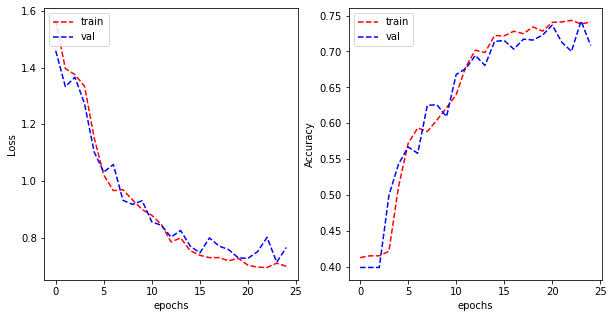

1980/1980 [==============================] - 5s 3ms/step - loss: 0.7331 - categorical_accuracy: 0.7288
Performance on test data:  [0.733139157295227, 0.728787899017334]


In [40]:
OUTPUT_CLASS = 4
model = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASS),
    ])
    
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
stopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=15, verbose=0, mode='auto', restore_best_weights=False)

model_history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0,
                                   callbacks = [stopper])

plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
print("Performance on test data: ", str(model.evaluate(test_generator)))

In [41]:
generate_stats_cellType(test_generator, model)

Accuracy score:  0.7287878787878788
F1 score:  0.6039431725242072
Precision Score:  0.7205990262763426
Recall Score:  0.6119299642234376
[[208  63  87   6]
 [ 22 416  81   4]
 [  5  26 786   1]
 [ 66 129  47  33]]


In this scenario, there is no overfitting, but there is a huge variance in the f1 score and accuracy. This can be improved using the oversampling technique to produce more images for the minority class. This is done in the further section.

In [42]:
model.save("Final_Model")

INFO:tensorflow:Assets written to: Final_Model\assets


In [43]:
model = tf.keras.models.load_model("Final_Model_1")

In [44]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 13, 13, 64)        32832     
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 13, 13, 64)        65600     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 6, 6, 64)        

## Loading the extra data

In [45]:
extra = pd.read_csv("data_labels_extraData.csv")

In [46]:
extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [47]:
images = extra["ImageName"].apply(add_path)

## Predicting cell type on extra data

In [48]:
def load_image(img_path):

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(27, 27))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    return img_tensor

In [49]:
image_class = {}

for image in images:
    new_image = load_image(image)
    pred_class = model.predict_classes(new_image)
    image_class[image] = pred_class

## Creating dataframe of extra data images

In [50]:
image_df = pd.DataFrame.from_dict(image_class, orient="index")

In [51]:
image_df = image_df.reset_index()

In [52]:
image_df.columns = ["ImageName","cellType"]

In [53]:
image_df.head()

,ImageName,cellType
0,./patch_images/12681.png,0
1,./patch_images/12682.png,0
2,./patch_images/12683.png,3
3,./patch_images/12684.png,0
4,./patch_images/12685.png,0


In [54]:
image_df.cellType.value_counts()

2    6766
1    2148
0    1061
3     409
Name: cellType, dtype: int64

## Creating new train data

Earlier we saw the model was not overfitting, however confusion matrix potrayed a different picture for cell type 3. This was obvious due less number of images. Here we can do oversampling technique, by introducing more images from the extra data for cell type 3. This can increase the model's performance. However the downside to this, the pseudo labels were generated by the model itself, so few images for cell type 3 won't be accurate.

In [96]:
new_train = train_data.append(image_df[(image_df["cellType"] == 3)], ignore_index=True)

In [97]:
new_train.isna().sum()

ImageName    0
cellType     0
dtype: int64

In [98]:
new_train['cellType'] = new_train['cellType'].astype('str')

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 128

train_generator = train_datagen.flow_from_dataframe(
        dataframe=new_train,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 6741 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.


## Retraining the model

In [99]:
OUTPUT_CLASSES = 4

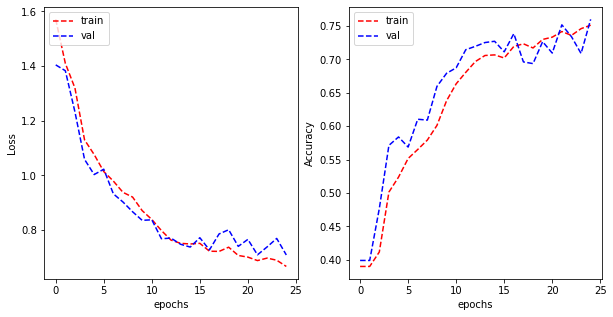

1980/1980 [==============================] - 5s 3ms/step - loss: 0.6947 - categorical_accuracy: 0.7404
Performance on test data:  [0.6946693658828735, 0.7404040694236755]


In [111]:
model_new = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(27, 27, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        #VGG block 3
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                               kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_CLASS),
    ])
    
model_new.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])
    
stopper = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=15, verbose=0, mode='auto', restore_best_weights=False)

model_history = model_new.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0,
                                   callbacks = [stopper])

plot_learning_curve(model_history.history['loss'], model_history.history['val_loss'], 
                    model_history.history['categorical_accuracy'], model_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
print("Performance on test data: ", str(model_new.evaluate(test_generator)))

In [112]:
generate_stats_cellType(test_generator, model_new)

Accuracy score:  0.73989898989899
F1 score:  0.6765575840761694
Precision Score:  0.6781478014281556
Recall Score:  0.6783337486330103
[[240  40  28  56]
 [ 23 419  25  56]
 [ 62  42 695  18]
 [ 43 103  19 111]]


The above statistics shows that, the model has improved it's performance in learning for cell type 3. This shows that, introducing more images for cell type 3 can improve the performance, as the imbalance is reduced.